In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import math
import cv2
from keras.models import model_from_json, load_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from keras.metrics import AUC
from sklearn.utils import class_weight
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df = pd.read_csv('fer2013.csv')
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
df.emotion.unique()

array([0, 2, 4, 6, 3, 5, 1], dtype=int64)

In [4]:
dim = int(math.sqrt(len(df.pixels[0].split(' '))))

In [5]:
emotion_count = df.emotion.value_counts()
print(emotion_count)

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64


<AxesSubplot:ylabel='emotion'>

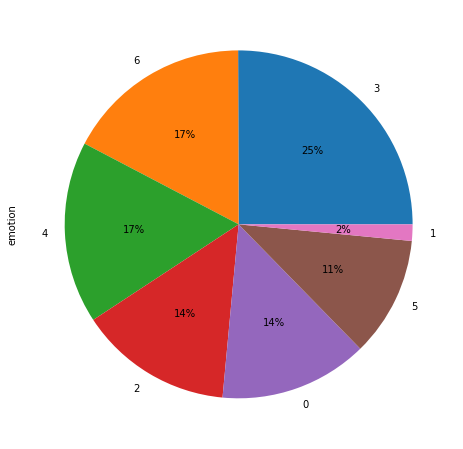

In [6]:
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

In [7]:
# emotion_label_to_text = {0:'Negative', 1:'Positive'}
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [8]:
def augment_pixels(px):
    image = np.array(px.split(' ')).reshape(48, 48).astype('float32')
    image = tf.image.random_flip_left_right(image.reshape(48, 48, 1))
    image = tf.image.random_brightness(image, max_delta=0.5)
    image = tf.clip_by_value(image, 0, 255)
    augmented_img = image.numpy().reshape(48, 48)
    img_concat = ' '.join(augmented_img.reshape(48*48).astype('int').astype(str))
    return img_concat

valcounts = df.emotion.value_counts()
valcounts_diff = valcounts[valcounts.idxmax()] - valcounts
for emotion_idx, aug_count in valcounts_diff.iteritems():
    sampled = df.query("emotion==@emotion_idx").sample(aug_count, replace=True)
    sampled['pixels'] = sampled.pixels.apply(augment_pixels)
    df = pd.concat([df, sampled])

In [9]:
emotion_count = df.emotion.value_counts()
print(emotion_count)

0    8989
2    8989
4    8989
6    8989
3    8989
5    8989
1    8989
Name: emotion, dtype: int64


<AxesSubplot:ylabel='emotion'>

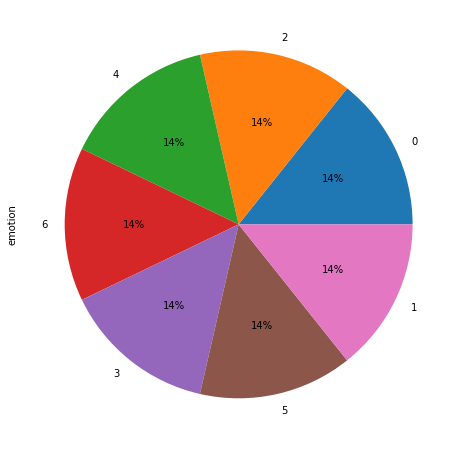

In [10]:
emotion_count.plot(kind='pie', autopct='%1.0f%%', figsize=(8, 8))

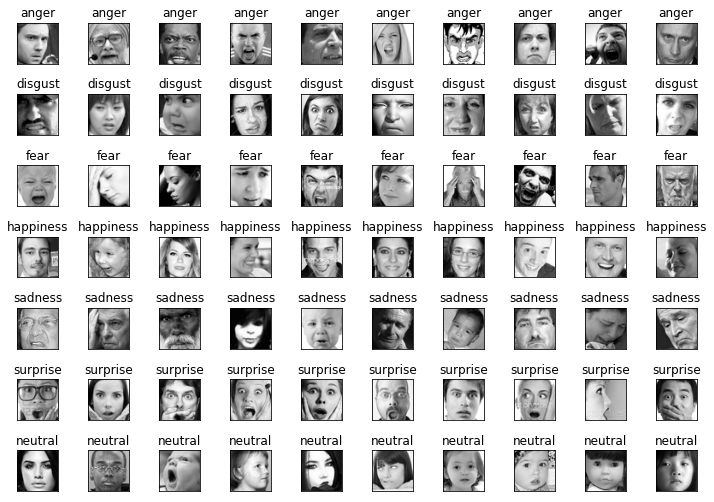

In [11]:
plt.figure(figsize=(10, 10))
counter = 0
for label in sorted(df.emotion.unique()):
    for i in range(10):
        px = df[df.emotion==label].pixels.iloc[counter]
        px = np.array(px.split(' ')).reshape(dim, dim).astype('float32')
        counter += 1
        ax = plt.subplot(10, 10, counter)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        plt.tight_layout()

In [12]:
img_df = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(dim, dim, 1).astype('float32'))
img_df = np.stack(img_df, axis=0)

In [13]:
img_df.shape

(62923, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(62923, 7)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(img_df, img_labels, shuffle=True, stratify=img_labels, test_size=0.1, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56630, 48, 48, 1), (6293, 48, 48, 1), (56630, 7), (6293, 7))

In [16]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [17]:
X_train = X_train / 255.
X_test = X_test / 255.

# X_train = X_train.reshape(len(X_train), 48 * 48 * 1)
# s = SMOTE(random_state=42)
# X_smote, y_smote = s.fit_resample(X_train, y_train)
# X_smote = X_smote.reshape(-1, 48, 48, 1)
# X_smote.shape

class_weights = class_weight.compute_sample_weight(class_weight='balanced', y=y_train)
class_weights = dict(enumerate(class_weights))

In [18]:
class Localization(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        
        super(Localization, self).__init__()
        self.pool1 = tf.keras.layers.MaxPool2D()
        self.conv1 = tf.keras.layers.Conv2D(24, [6, 6], activation='relu')
        self.pool2 = tf.keras.layers.MaxPool2D()
        self.conv2 = tf.keras.layers.Conv2D(24, [6, 6], activation='relu')
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(24, activation='relu')
        self.fc2 = tf.keras.layers.Dense(6, activation=None, bias_initializer=tf.keras.initializers.constant([1.0, 0.0, 0.0, 0.0, 1.0, 0.0]), kernel_initializer='zeros')

    def build(self, input_shape):
        
        print("Building Localization Network with input shape:", input_shape)

    def compute_output_shape(self, input_shape):
        
        return [None, 6]

    def call(self, inputs):
        
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        theta = self.fc2(x)
        theta = tf.keras.layers.Reshape((2, 3))(theta)
        return theta

In [19]:
class GridGenerator_Sampler(tf.keras.layers.Layer):
    def __init__(self, height=48, width=48, **kwargs):
        
        super(GridGenerator_Sampler, self).__init__()
        self.height = height
        self.width = width

    def compute_output_shape(self, input_shape):
        
        return [None, self.height, self.width, 1]

    def get_config(self):
        
        return {
            'height': self.height,
            'width': self.width,
        }
    
    def build(self, input_shape):
        
        print("Building Bilinear Interpolation Layer with input shape:", input_shape)

    def advance_indexing(self, inputs, x, y):       
        
        shape = tf.shape(inputs)
        batch_size, _, _ = shape[0], shape[1], shape[2]
        
        batch_idx = tf.range(0, batch_size)
        batch_idx = tf.reshape(batch_idx, (batch_size, 1, 1))
        b = tf.tile(batch_idx, (1, self.height, self.width))
        indices = tf.stack([b, y, x], 3)
        return tf.gather_nd(inputs, indices)

    def call(self, inputs):
        
        images, theta = inputs
        homogenous_coordinates = self.grid_generator(batch=tf.shape(images)[0])
        return self.interpolate(images, homogenous_coordinates, theta)

    def grid_generator(self, batch):
        
        x = tf.linspace(-1, 1, self.width)
        y = tf.linspace(-1, 1, self.height)
            
        xx, yy = tf.meshgrid(x, y)
        xx = tf.reshape(xx, (-1,))
        yy = tf.reshape(yy, (-1,))
        homogenous_coordinates = tf.stack([xx, yy, tf.ones_like(xx)])
        homogenous_coordinates = tf.expand_dims(homogenous_coordinates, axis=0)
        homogenous_coordinates = tf.tile(homogenous_coordinates, [batch, 1, 1])
        homogenous_coordinates = tf.cast(homogenous_coordinates, dtype=tf.float32)
        return homogenous_coordinates
    
    def interpolate(self, images, homogenous_coordinates, theta):

        with tf.name_scope("Transformation"):
            transformed = tf.matmul(theta, homogenous_coordinates)
            transformed = tf.transpose(transformed, perm=[0, 2, 1])
            transformed = tf.reshape(transformed, [-1, self.height, self.width, 2])
                
            x_transformed = transformed[:, :, :, 0]
            y_transformed = transformed[:, :, :, 1]
                
            x = ((x_transformed + 1.) * tf.cast(self.width, dtype=tf.float32)) * 0.5
            y = ((y_transformed + 1.) * tf.cast(self.height, dtype=tf.float32)) * 0.5

        with tf.name_scope("VariableCasting"):
            x0 = tf.cast(tf.math.floor(x), dtype=tf.int32)
            x1 = x0 + 1
            y0 = tf.cast(tf.math.floor(y), dtype=tf.int32)
            y1 = y0 + 1

            x0 = tf.clip_by_value(x0, 0, self.width-1)
            x1 = tf.clip_by_value(x1, 0, self.width-1)
            y0 = tf.clip_by_value(y0, 0, self.height-1)
            y1 = tf.clip_by_value(y1, 0, self.height-1)
            x = tf.clip_by_value(x, 0, tf.cast(self.width, dtype=tf.float32)-1.0)
            y = tf.clip_by_value(y, 0, tf.cast(self.height, dtype=tf.float32)-1)

        with tf.name_scope("AdvanceIndexing"):
            Ia = self.advance_indexing(images, x0, y0)
            Ib = self.advance_indexing(images, x0, y1)
            Ic = self.advance_indexing(images, x1, y0)
            Id = self.advance_indexing(images, x1, y1)

        with tf.name_scope("Interpolation"):
            x0 = tf.cast(x0, dtype=tf.float32)
            x1 = tf.cast(x1, dtype=tf.float32)
            y0 = tf.cast(y0, dtype=tf.float32)
            y1 = tf.cast(y1, dtype=tf.float32)
                            
            wa = (x1-x) * (y1-y)
            wb = (x1-x) * (y-y0)
            wc = (x-x0) * (y1-y)
            wd = (x-x0) * (y-y0)

            wa = tf.expand_dims(wa, axis=3)
            wb = tf.expand_dims(wb, axis=3)
            wc = tf.expand_dims(wc, axis=3)
            wd = tf.expand_dims(wd, axis=3)
                        
        return tf.math.add_n([wa*Ia + wb*Ib + wc*Ic + wd*Id])

In [21]:
# def get_stn_model(input_shape):
    
#     image = tf.keras.layers.Input(shape=input_shape)
#     theta = Localization()(image)
    
#     x = BilinearInterpolation(height=input_shape[0], width=input_shape[1])([image, theta])
#     x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
#     x = tf.keras.layers.MaxPool2D()(x)
    
#     x = tf.keras.layers.Conv2D(filters=64, kernel_size=(5, 5), activation='relu')(x)
#     x = tf.keras.layers.MaxPool2D()(x)
    
#     x = tf.keras.layers.Flatten()(x)
#     x = tf.keras.layers.Dense(64, activation='relu')(x)
#     x = tf.keras.layers.Dense(32, activation='relu')(x)
#     x = tf.keras.layers.Dense(7, activation='softmax')(x)

#     return tf.keras.models.Model(inputs=image, outputs=x)

In [22]:
def get_stn_model(input_shape):
    
    image = tf.keras.layers.Input(shape=input_shape)
    theta = Localization()(image)
    
    x = GridGenerator_Sampler(height=input_shape[0], width=input_shape[1])([image, theta])
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        input_shape=input_shape,
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(image)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=64,
        kernel_size=(5,5),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)


    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=128,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.4)(x)

    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.Conv2D(
        filters=256,
        kernel_size=(3,3),
        activation='relu',
        padding='same',
        kernel_initializer='he_normal',
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    x = tf.keras.layers.Flatten()(x)
        
    x = tf.keras.layers.Dense(
        256,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        512,
        activation='relu',
        kernel_initializer='he_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        bias_regularizer=tf.keras.regularizers.l2(0.01)
    )(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.Dense(
        7,
        activation='softmax',
    )(x)
    
    return tf.keras.models.Model(inputs=image, outputs=x)

In [23]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True, min_delta=0.0001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint(filepath='./best_weight_STN7_base.h5', mode='max', monitor='val_accuracy', verbose=1, save_best_only=True)
# datagen = ImageDataGenerator(rotation_range=10, brightness_range=[0.6,1], horizontal_flip=True, featurewise_center=True, featurewise_std_normalization=True)

# datagen.fit(X_train)

In [24]:
X = np.concatenate((X_train, X_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=5, random_state=42, shuffle=True)
fold_count = 1
for train, test in kfold.split(X, y):
    stn_model = get_stn_model((48, 48, 1))
    batch_size = 32
    stn_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                      metrics=['accuracy', AUC(multi_label=True, num_labels=7)])
    print(f'\nFold {fold_count}/5')
    stn_model.fit(X[train], y[train], validation_split=0.1, batch_size=batch_size, steps_per_epoch=len(X[train])/batch_size,
                  epochs=60, callbacks=[reduce_lr, checkpoint, es_callback])
    
    scores = stn_model.evaluate(X[test], y[test])
    print(f'Fold {fold_count}/5 - {stn_model.metrics_names[0]}: {scores[0]} - {stn_model.metrics_names[1]}: {round(scores[1]*100, 2)}%\n')
    loss_per_fold.append(scores[0])
    acc_per_fold.append(round(scores[1]*100, 2))

    fold_count = fold_count + 1
    
print(f'val_loss_avg: {np.mean(loss_per_fold)}')
print(f'val_acc_avg: {round(np.mean(acc_per_fold), 2)}%')



Fold 1/5
Epoch 1/60
1572/1573 [============================>.] - ETA: 0s - loss: 5.1264 - accuracy: 0.3142 - auc: 0.6826
Epoch 1: val_accuracy improved from -inf to 0.44398, saving model to .\best_weight_STN7_base.h5
1573/1573 [==============================] - 34s 19ms/step - loss: 5.1228 - accuracy: 0.3145 - auc: 0.6827 - val_loss: 2.3952 - val_accuracy: 0.4440 - val_auc: 0.7902 - lr: 0.0010
Epoch 2/60
1574/1573 [==============================] - ETA: 0s - loss: 2.2017 - accuracy: 0.4607 - auc: 0.8024
Epoch 2: val_accuracy improved from 0.44398 to 0.51331, saving model to .\best_weight_STN7_base.h5
1573/1573 [==============================] - 29s 18ms/step - loss: 2.2017 - accuracy: 0.4607 - auc: 0.8024 - val_loss: 2.1450 - val_accuracy: 0.5133 - val_auc: 0.8385 - lr: 0.0010
Epoch 3/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.2191 - accuracy: 0.5099 - auc: 0.8315
Epoch 3: val_accuracy improved from 0.51331 to 0.55085, saving model to .\best_weight_STN7_base.h5


Epoch 23/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.3436 - accuracy: 0.7220 - auc: 0.9368
Epoch 23: val_accuracy improved from 0.70739 to 0.71136, saving model to .\best_weight_STN7_base.h5
1573/1573 [==============================] - 29s 19ms/step - loss: 1.3436 - accuracy: 0.7220 - auc: 0.9368 - val_loss: 1.3546 - val_accuracy: 0.7114 - val_auc: 0.9341 - lr: 0.0010
Epoch 24/60
1572/1573 [============================>.] - ETA: 0s - loss: 1.3279 - accuracy: 0.7235 - auc: 0.9374
Epoch 24: val_accuracy did not improve from 0.71136
1573/1573 [==============================] - 29s 19ms/step - loss: 1.3278 - accuracy: 0.7235 - auc: 0.9374 - val_loss: 1.3871 - val_accuracy: 0.7090 - val_auc: 0.9327 - lr: 0.0010
Epoch 25/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.3185 - accuracy: 0.7295 - auc: 0.9394
Epoch 25: val_accuracy improved from 0.71136 to 0.71633, saving model to .\best_weight_STN7_base.h5
1573/1573 [==============================] - 29s 

Epoch 2/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.1906 - accuracy: 0.4524 - auc_1: 0.7976
Epoch 2: val_accuracy did not improve from 0.74950
1573/1573 [==============================] - 34s 21ms/step - loss: 2.1908 - accuracy: 0.4523 - auc_1: 0.7976 - val_loss: 2.1815 - val_accuracy: 0.4863 - val_auc_1: 0.8339 - lr: 0.0010
Epoch 3/60
1574/1573 [==============================] - ETA: 0s - loss: 2.2431 - accuracy: 0.4990 - auc_1: 0.8286
Epoch 3: val_accuracy did not improve from 0.74950
1573/1573 [==============================] - 34s 21ms/step - loss: 2.2431 - accuracy: 0.4990 - auc_1: 0.8286 - val_loss: 2.4176 - val_accuracy: 0.4776 - val_auc_1: 0.8311 - lr: 0.0010
Epoch 4/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.1784 - accuracy: 0.5332 - auc_1: 0.8484
Epoch 4: val_accuracy did not improve from 0.74950
1573/1573 [==============================] - 33s 21ms/step - loss: 2.1785 - accuracy: 0.5331 - auc_1: 0.8484 - val_loss: 2.1111 - val_acc

1573/1573 [==============================] - 30s 19ms/step - loss: 1.3008 - accuracy: 0.7303 - auc_1: 0.9408 - val_loss: 1.3686 - val_accuracy: 0.7157 - val_auc_1: 0.9338 - lr: 0.0010
Epoch 26/60
1572/1573 [============================>.] - ETA: 0s - loss: 1.2826 - accuracy: 0.7347 - auc_1: 0.9426
Epoch 26: val_accuracy did not improve from 0.74950
1573/1573 [==============================] - 29s 19ms/step - loss: 1.2825 - accuracy: 0.7348 - auc_1: 0.9426 - val_loss: 1.3560 - val_accuracy: 0.7233 - val_auc_1: 0.9358 - lr: 0.0010
Epoch 27/60
1574/1573 [==============================] - ETA: 0s - loss: 1.2696 - accuracy: 0.7390 - auc_1: 0.9439
Epoch 27: val_accuracy did not improve from 0.74950
1573/1573 [==============================] - 29s 18ms/step - loss: 1.2696 - accuracy: 0.7390 - auc_1: 0.9439 - val_loss: 1.3562 - val_accuracy: 0.7209 - val_auc_1: 0.9366 - lr: 0.0010
Epoch 28/60
1574/1573 [==============================] - ETA: 0s - loss: 1.2690 - accuracy: 0.7450 - auc_1: 0.9464

Epoch 2/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.2005 - accuracy: 0.4487 - auc_2: 0.7952
Epoch 2: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 19ms/step - loss: 2.2007 - accuracy: 0.4486 - auc_2: 0.7951 - val_loss: 2.3033 - val_accuracy: 0.4321 - val_auc_2: 0.7987 - lr: 0.0010
Epoch 3/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.2232 - accuracy: 0.5019 - auc_2: 0.8285
Epoch 3: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 19ms/step - loss: 2.2233 - accuracy: 0.5019 - auc_2: 0.8285 - val_loss: 2.3260 - val_accuracy: 0.4805 - val_auc_2: 0.8375 - lr: 0.0010
Epoch 4/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.1999 - accuracy: 0.5345 - auc_2: 0.8460
Epoch 4: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 30s 19ms/step - loss: 2.1999 - accuracy: 0.5346 - auc_2: 0.8460 - val_loss: 2.1676 - val_acc

1573/1573 [==============================] - 33s 21ms/step - loss: 1.2977 - accuracy: 0.7270 - auc_2: 0.9389 - val_loss: 1.2977 - val_accuracy: 0.7213 - val_auc_2: 0.9387 - lr: 0.0010
Epoch 26/60
1572/1573 [============================>.] - ETA: 0s - loss: 1.2823 - accuracy: 0.7315 - auc_2: 0.9412
Epoch 26: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 32s 20ms/step - loss: 1.2822 - accuracy: 0.7316 - auc_2: 0.9412 - val_loss: 1.3424 - val_accuracy: 0.7040 - val_auc_2: 0.9365 - lr: 0.0010
Epoch 27/60
1572/1573 [============================>.] - ETA: 0s - loss: 1.2710 - accuracy: 0.7364 - auc_2: 0.9432
Epoch 27: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 30s 19ms/step - loss: 1.2709 - accuracy: 0.7364 - auc_2: 0.9431 - val_loss: 1.2877 - val_accuracy: 0.7255 - val_auc_2: 0.9386 - lr: 0.0010
Epoch 28/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.2417 - accuracy: 0.7434 - auc_2: 0.9450

1573/1573 [==============================] - 29s 18ms/step - loss: 1.8774 - accuracy: 0.6238 - auc_3: 0.8958 - val_loss: 1.8678 - val_accuracy: 0.6204 - val_auc_3: 0.9000 - lr: 0.0010
Epoch 10/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.7898 - accuracy: 0.6340 - auc_3: 0.9010
Epoch 10: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 18ms/step - loss: 1.7898 - accuracy: 0.6340 - auc_3: 0.9010 - val_loss: 1.7794 - val_accuracy: 0.6373 - val_auc_3: 0.9054 - lr: 0.0010
Epoch 11/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.7639 - accuracy: 0.6456 - auc_3: 0.9049
Epoch 11: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 18ms/step - loss: 1.7639 - accuracy: 0.6456 - auc_3: 0.9049 - val_loss: 1.7350 - val_accuracy: 0.6806 - val_auc_3: 0.9185 - lr: 0.0010
Epoch 12/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.7083 - accuracy: 0.6510 - auc_3: 0.9085

Epoch 33/60
1572/1573 [============================>.] - ETA: 0s - loss: 1.1858 - accuracy: 0.7594 - auc_3: 0.9509
Epoch 33: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 18ms/step - loss: 1.1860 - accuracy: 0.7594 - auc_3: 0.9509 - val_loss: 1.3042 - val_accuracy: 0.7318 - val_auc_3: 0.9390 - lr: 0.0010
Epoch 34/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.1776 - accuracy: 0.7637 - auc_3: 0.9525
Epoch 34: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 18ms/step - loss: 1.1779 - accuracy: 0.7636 - auc_3: 0.9525 - val_loss: 1.2683 - val_accuracy: 0.7366 - val_auc_3: 0.9420 - lr: 0.0010
Epoch 35/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.1641 - accuracy: 0.7683 - auc_3: 0.9539
Epoch 35: val_accuracy did not improve from 0.76023
1573/1573 [==============================] - 29s 18ms/step - loss: 1.1642 - accuracy: 0.7683 - auc_3: 0.9538 - val_loss: 1.2879 - v

Epoch 4/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.2208 - accuracy: 0.5375 - auc_4: 0.8495
Epoch 4: val_accuracy did not improve from 0.77811
1573/1573 [==============================] - 29s 18ms/step - loss: 2.2208 - accuracy: 0.5376 - auc_4: 0.8496 - val_loss: 2.3099 - val_accuracy: 0.5576 - val_auc_4: 0.8714 - lr: 0.0010
Epoch 5/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.1276 - accuracy: 0.5616 - auc_4: 0.8647
Epoch 5: val_accuracy did not improve from 0.77811
1573/1573 [==============================] - 29s 18ms/step - loss: 2.1276 - accuracy: 0.5616 - auc_4: 0.8647 - val_loss: 2.0250 - val_accuracy: 0.6103 - val_auc_4: 0.8912 - lr: 0.0010
Epoch 6/60
1573/1573 [============================>.] - ETA: 0s - loss: 2.0788 - accuracy: 0.5827 - auc_4: 0.8751
Epoch 6: val_accuracy did not improve from 0.77811
1573/1573 [==============================] - 29s 18ms/step - loss: 2.0788 - accuracy: 0.5826 - auc_4: 0.8750 - val_loss: 1.8862 - val_acc

1573/1573 [==============================] - 29s 18ms/step - loss: 1.2400 - accuracy: 0.7399 - auc_4: 0.9450 - val_loss: 1.2764 - val_accuracy: 0.7372 - val_auc_4: 0.9414 - lr: 0.0010
Epoch 28/60
1574/1573 [==============================] - ETA: 0s - loss: 1.2365 - accuracy: 0.7467 - auc_4: 0.9463
Epoch 28: val_accuracy did not improve from 0.77811
1573/1573 [==============================] - 29s 18ms/step - loss: 1.2365 - accuracy: 0.7467 - auc_4: 0.9463 - val_loss: 1.2950 - val_accuracy: 0.7279 - val_auc_4: 0.9389 - lr: 0.0010
Epoch 29/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.2099 - accuracy: 0.7490 - auc_4: 0.9474
Epoch 29: val_accuracy did not improve from 0.77811
1573/1573 [==============================] - 29s 18ms/step - loss: 1.2098 - accuracy: 0.7490 - auc_4: 0.9474 - val_loss: 1.2971 - val_accuracy: 0.7326 - val_auc_4: 0.9396 - lr: 0.0010
Epoch 30/60
1573/1573 [============================>.] - ETA: 0s - loss: 1.2140 - accuracy: 0.7499 - auc_4: 0.9481

Classification Report:

              precision    recall  f1-score   support

       anger       0.58      0.81      0.67       899
     disgust       0.98      1.00      0.99       899
        fear       0.79      0.45      0.57       899
   happiness       0.86      0.82      0.84       899
     sadness       0.65      0.65      0.65       899
    surprise       0.88      0.91      0.89       899
     neutral       0.73      0.75      0.74       899

    accuracy                           0.77      6293
   macro avg       0.78      0.77      0.77      6293
weighted avg       0.78      0.77      0.77      6293



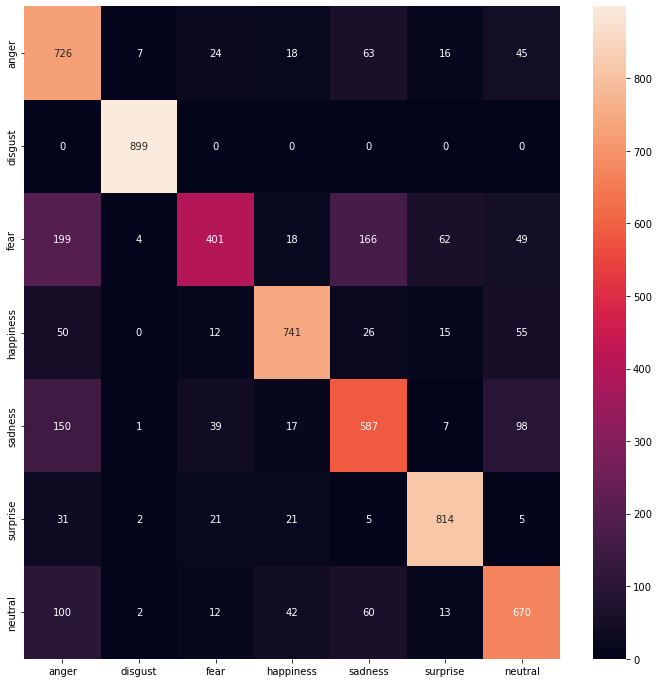

In [25]:
class_types = ['anger','disgust','fear','happiness','sadness', 'surprise', 'neutral']
def conf_matrix(predictions): 

    rounded_labels = np.argmax(y_test, axis=1)
    cm = confusion_matrix(rounded_labels, np.argmax(np.round(predictions), axis=1))
    print("Classification Report:\n")
    cr = classification_report(rounded_labels, np.argmax(np.round(predictions), axis=1), 
                                target_names=[class_types[i] for i in range(len(class_types))])
    print(cr)
    plt.figure(figsize=(12, 12))
    sns_hmp = sns.heatmap(cm, annot=True, xticklabels=[class_types[i] for i in range(len(class_types))], 
                yticklabels=[class_types[i] for i in range(len(class_types))], fmt="d")
    fig = sns_hmp.get_figure()

saved_stn_model = load_model('best_weight_STN7_base.h5', custom_objects={'Localization': Localization, 'BilinearInterpolation': BilinearInterpolation})
pred_class = saved_stn_model.predict(X_test)
conf_matrix(pred_class)

In [28]:
model_json = stn_model.to_json()
with open("stn7_model_base.json", "w") as json_file:
    json_file.write(model_json)

In [27]:
# from keras.preprocessing import image

# json_file = open('stn_model.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# emotion_model = model_from_json(loaded_model_json, custom_objects={'Localization': Localization, 'BilinearInterpolation': BilinearInterpolation})

# emotion_model.load_weights("best_weight_STN7.h5")
# print("Loaded model from disk")

# face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
# cap = cv2.VideoCapture(0)

# while True:
#     ret, frame = cap.read()
#     if not ret:
#         break
        
#     gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

#     num_faces = face_detector.detectMultiScale(gray_frame, scaleFactor=1.3, minNeighbors=5)

#     for (x, y, w, h) in num_faces:
#         cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 0, 255), 2)
#         roi_gray_frame = gray_frame[y: y+w, x: x+h]
#         roi_gray_frame = cv2.resize(roi_gray_frame, (48, 48))
#         image_pixels = image.img_to_array(roi_gray_frame)
#         image_pixels = np.expand_dims(image_pixels, axis=0)
#         image_pixels /= 255

#         emotion_prediction = emotion_model.predict(image_pixels)
#         maxindex = np.argmax(emotion_prediction[0])
#         cv2.putText(frame, emotion_label_to_text[maxindex], (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

#     cv2.imshow('Emotion Detection', frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()